In [1]:
#Qiskit Aer: Pulse simulation of a backend model
#This notebook shows how to use the Aer pulse simulator using a model generated from a backend. 
#In particular, we run a Rabi experiment to find a 𝜋-pulse amplitude on a model of the Armonk one qubit backend, generated from the FakeArmonk mock backend.

In [3]:
#Contents
#1.Imports
#2.Construct model from backend
#3.Run Rabi experiments and fit :math:pi`-pulse amplitude <#rabi>`__

In [4]:
#1.Imports
import numpy as np
#Import Rabi experiment generator and fitter from Ignis, and other functions for job submission:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

In [5]:
#Import PulseSimulator and PulseSystemModel for pulse simulation, as well as the mock Armonk backend:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

In [6]:
#2. Construct model from backend
#This section demonstrates the use of the PulseSystemModel.from_backend function for generating PulseSystemModel objects from a backend.
#Instantiate mock backend:
armonk_backend = FakeArmonk()

In [7]:
#Manual insertion of Hamiltonian parameters:
#Caution: Hamiltonian parameters are required for FAKE BACKEND
# set the drive strength
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85

# set the qubit frequency
# Caution: the frequency of the qubit of the real backend, look up the frequency in the spec in IBMQ
freq_est = 4.97e9
armonk_backend.defaults().qubit_freq_est = [freq_est]
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

In [8]:
#Generate model from backend:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

In [8]:
#3.Run Rabi experiments and fit 𝜋-pulse amplitude
#Next, we run a Rabi experiments generated using Ignis on the simulator using the system model generated from the Armonk backend.

In [9]:
#First, construct Rabi experiment schedules:
# qubit list
qubit = 0

#Number of shots
num_shots = 2048

# drive shape parameters
total_duration = 4096
total_sigma = total_duration/8
num_dur = 65
drive_duration = np.linspace(0, total_duration, num_dur)
drive_duration = np.delete(drive_duration, 0)
drive_sigma = np.linspace(0,total_sigma, num_dur)
drive_sigma = np.delete(drive_sigma,0)
print(drive_duration)

# drive amplitudes to use
num_exps = 3
drive_amps = np.linspace(0.25, 1.0, num_exps)
print(drive_amps)

# list of drive channels
drive_channels = [DriveChannel(0)]

[  64.  128.  192.  256.  320.  384.  448.  512.  576.  640.  704.  768.
  832.  896.  960. 1024. 1088. 1152. 1216. 1280. 1344. 1408. 1472. 1536.
 1600. 1664. 1728. 1792. 1856. 1920. 1984. 2048. 2112. 2176. 2240. 2304.
 2368. 2432. 2496. 2560. 2624. 2688. 2752. 2816. 2880. 2944. 3008. 3072.
 3136. 3200. 3264. 3328. 3392. 3456. 3520. 3584. 3648. 3712. 3776. 3840.
 3904. 3968. 4032. 4096.]
[0.25  0.625 1.   ]


In [10]:
from qiskit import pulse 
from qiskit.pulse import library
from qiskit.scheduler import measure 

<ipython-input-11-77b584944b46>:8: DeprecationWarning: "measure" has been moved to "qiskit.pulse.macros"
  sched += measure([qubit], armonk_backend) << sched.duration


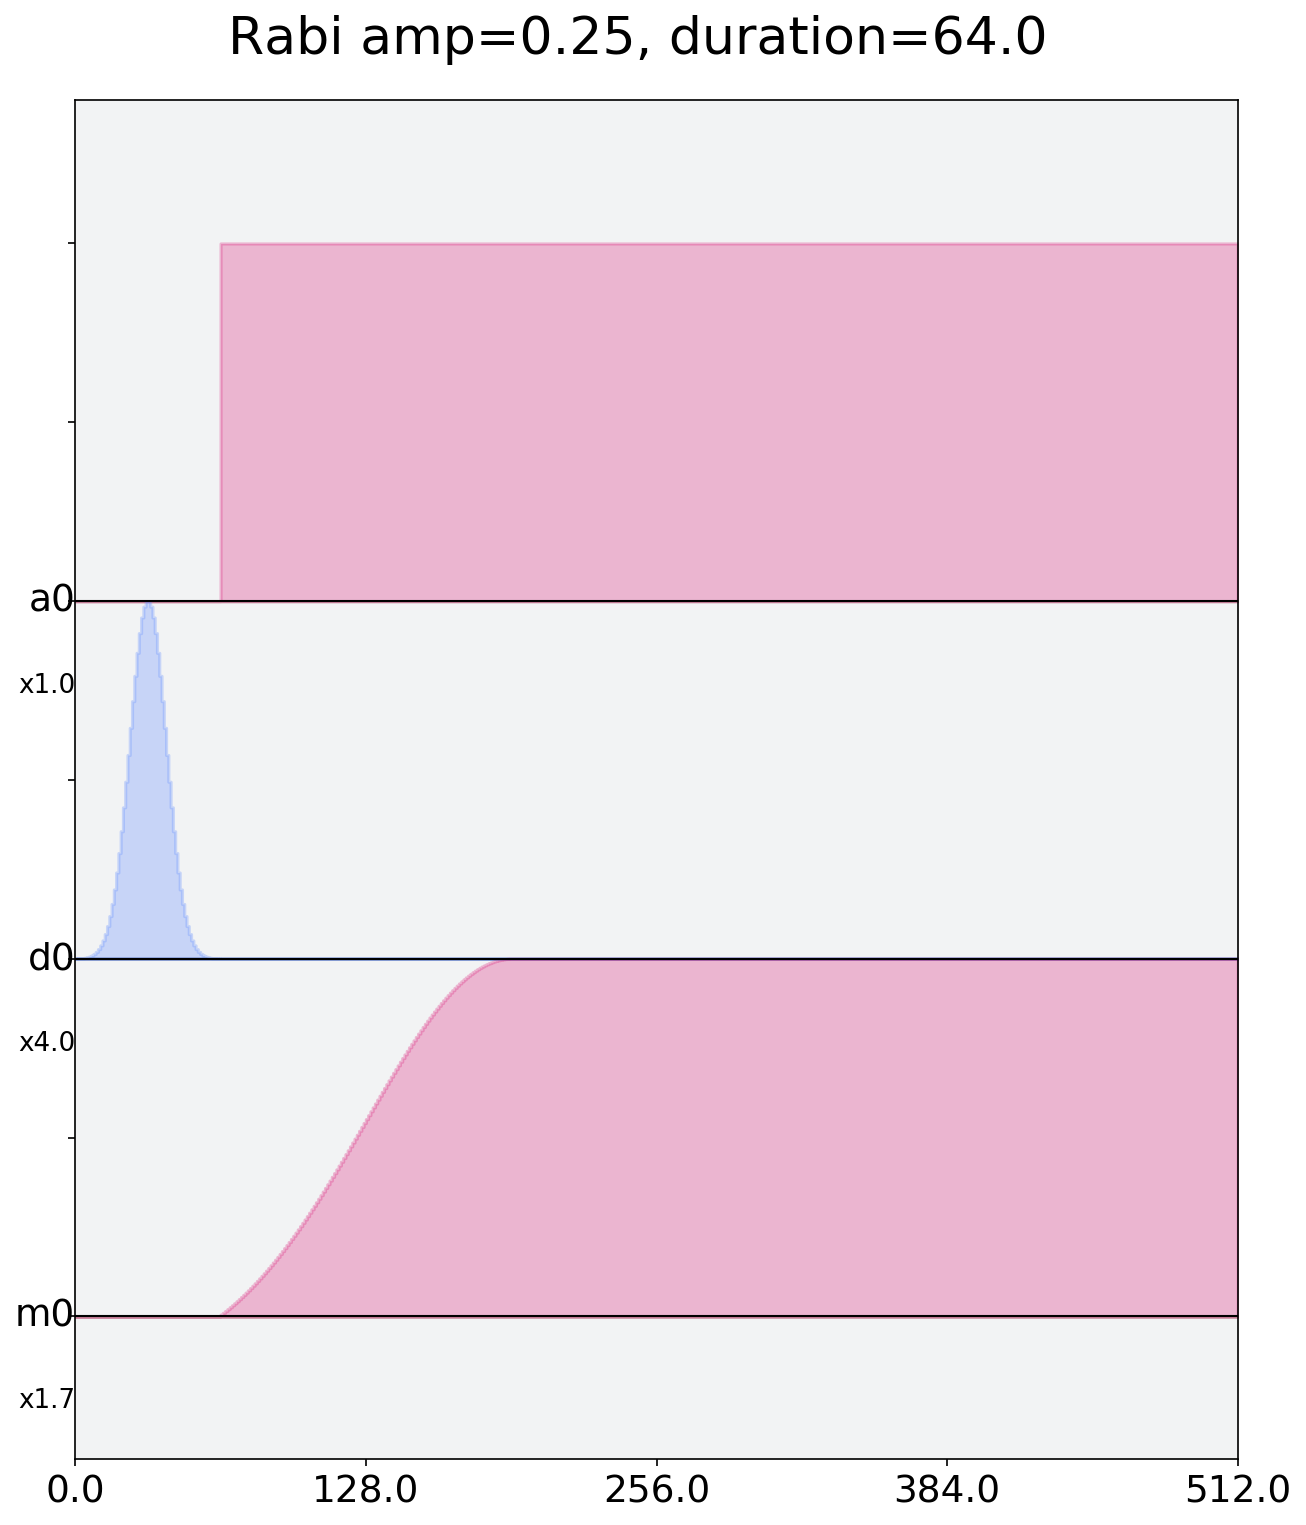

In [11]:
backend_sim = PulseSimulator()

rabi_schedules=[]
for amp in drive_amps:
    for i in range(len(drive_duration)):
        sched = pulse.Schedule(name='Rabi amp={}, duration={}'.format(amp, drive_duration[i]))
        sched += pulse.Play(library.Gaussian(int(drive_duration[i]),amp,int(drive_sigma[i])).get_waveform(),pulse.DriveChannel(qubit))
        sched += measure([qubit], armonk_backend) << sched.duration
        rabi_schedules.append(sched)
    
    #Assemble the qobj for job submission. 
    #When assembling pulse schedules to be used with the pulse simulator, pass the PulseSimulator as the backend.
rabi_schedules[0].draw(plot_range=[0,512])
#rabi_schedules[-1].draw(plot_range=[0,4096])

In [13]:
rabi_qobj = assemble(rabi_schedules,
                 backend=backend_sim,
                 meas_level=1,
                 meas_return='avg',
                 shots=num_shots)
#Run the simulation:
sim_result = backend_sim.run(rabi_qobj, armonk_model).result()

/Users/DannaHugo/anaconda2/envs/IBM/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(


In [14]:
cnt_sched = 0
response  = []
for amp in drive_amps:
    resp_Amp = []
    for i in range(len(drive_duration)):
        resp_Amp.append(sim_result.get_memory(cnt_sched)[qubit])
        cnt_sched = cnt_sched + 1
    response.append(resp_Amp)    
print(len(response))

3


/Users/DannaHugo/anaconda2/envs/IBM/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


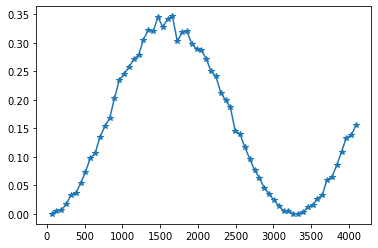

In [38]:
import matplotlib.pyplot as plt 

plt.plot(drive_duration, response[0],'-*')

In [31]:
from scipy.optimize import curve_fit
def cos_fit_func(x, A,B, w, phi):
    return B + A * np.cos(2*np.pi*x*w + phi)

def fit_Freq(x, y, xMax):
    """  [default]   xMax = 2.5

    """
    y2 = 1/np.abs(np.max(y)) * np.real(y)
    x2 = np.linspace(0, xMax, len(x))
    plt.plot(x2, y2,'-*')

    fitparams, conv = curve_fit(cos_fit_func, x2, y2, [ 1,  0,  1, 0])
    a0, b0, w0, phi0 = fitparams
    print(' ***************** ')
    print(a0, b0, w0, phi0)
    plt.plot(x2,cos_fit_func(x2, *fitparams),'.-',x2, y2,'-*')
    
    # --------- rescaling back to the original unit  ------- #
    dT1 = x[1]   - x[0]
    dx2 = x2[1] - x2[0]
    Freq = w0 * (dx2/dT1)
    print(dx2, dT1, dx2/dT1, w0, Freq)

    return a0, b0, w0, phi0, Freq
    

# Get the 1st fine tune guess & fitting

 ***************** 
-0.8477788862031971 0.0978380131903856 1.0175150754869966 0.16137801858146025
0.019047619047619046 64.0 0.0002976190476190476 1.0175150754869966 0.00030283186770446323


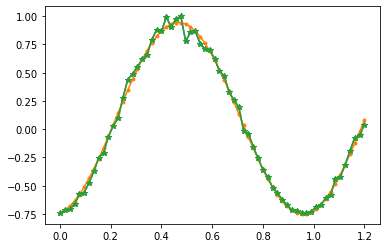

In [36]:
xMax = 1.2
response0 =  response[0] - np.mean( response[0] )
a0, b0, w0, phi0, Freq = fit_Freq(drive_duration, response0, xMax)

fparm_List = [np.array([a0, b0, w0, phi0])]
Amp_List   = [amp]
w0_List     = [w0]
Freq_List   = [Freq]
xMax_List  = [xMax]

#  More schedules:  changing both Amplitude & durations

amp=0.625, xMax_scale=3.0
amp=1.0, xMax_scale=4.8


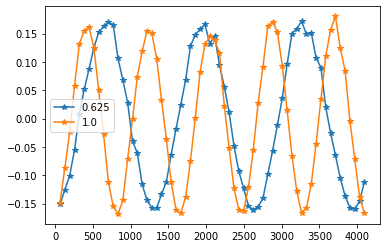

In [43]:
for cnt in np.arange(1, len(drive_amps)):
    resp_Amp = response[cnt]
    resp_Amp = resp_Amp - np.mean(resp_Amp) 
    amp         = drive_amps[cnt]
    xMax_scal = xMax_List[-1] * (amp/Amp_List[-1])     #  estimated scaled  xMax
    print('amp={}, xMax_scale={}'.format(amp, xMax_scal))
    #print(resp_Amp)

    plt.plot(drive_duration,np.real(resp_Amp),'-*')
plt.legend(drive_amps[1:])

In [75]:
#Generate the Rabi oscillation plot and find the 𝜋-pulse amplitude:
#rabi_fit = RabiFitter(sim_result, drive_duration, [qubit], fit_p0 = [1.5, 2, 0, 0])
# plot
# rabi_fit.plot(0)

amp=0.625, xMax_scale=3.0
 ***************** 
-0.9545331366396287 0.030077323620000696 1.0222901117248167 0.3152475243036909
0.047619047619047616 64.0 0.000744047619047619 1.0222901117248167 0.0007606325236047742
amp=1.0, xMax_scale=4.800000000000001
 ***************** 
-0.9169364360393771 -0.0028339159931024065 1.0222051731229198 0.4818789563857877
0.0761904761904762 64.0 0.0011904761904761906 1.0222051731229198 0.0012169109203844285


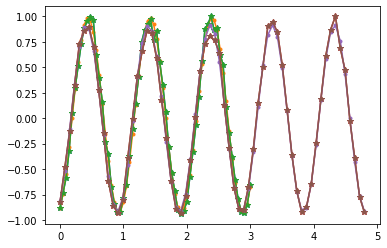

In [44]:
for cnt in np.arange(1, len(drive_amps)):
    resp_Amp = response[cnt]
    resp_Amp = resp_Amp - np.mean(resp_Amp) 
    amp         = drive_amps[cnt]
    xMax_scal = xMax_List[-1] * (amp/Amp_List[-1])     #  estimated scaled  xMax
    print('amp={}, xMax_scale={}'.format(amp, xMax_scal))

    a0, b0, w0, phi0, Freq = fit_Freq(drive_duration, resp_Amp, xMax_scal)
    
    Amp_List.append(amp)
    w0_List.append(w0)
    Freq_List.append(Freq)
    xMax_List.append(xMax_scal)
    fparm_List.append(np.array([a0, b0, w0, phi0]))


In [45]:
print(Amp_List)
print(w0_List)
print(Freq_List)
print(xMax_List)
print(fparm_List)

[0.25, 0.625, 1.0]
[1.0175150754869966, 1.0222901117248167, 1.0222051731229198]
[0.00030283186770446323, 0.0007606325236047742, 0.0012169109203844285]
[1.2, 3.0, 4.800000000000001]
[array([-0.84777889,  0.09783801,  1.01751508,  0.16137802]), array([-0.95453314,  0.03007732,  1.02229011,  0.31524752]), array([-0.91693644, -0.00283392,  1.02220517,  0.48187896])]


In [46]:
IDsort = np.argsort(Amp_List);                  print(IDsort)
Amp_List = np.array(Amp_List)[IDsort];      print(Amp_List)
w0_List    = np.array(w0_List)[IDsort];               print(w0_List)
Freq_List  = np.array(Freq_List)[IDsort];             print(Freq_List)
xMax_List  = np.array(xMax_List)[IDsort];           print(xMax_List)
fparm_List = np.array(fparm_List)[IDsort,:];       print(fparm_List)   

[0 1 2]
[0.25  0.625 1.   ]
[1.01751508 1.02229011 1.02220517]
[0.00030283 0.00076063 0.00121691]
[1.2 3.  4.8]
[[-0.84777889  0.09783801  1.01751508  0.16137802]
 [-0.95453314  0.03007732  1.02229011  0.31524752]
 [-0.91693644 -0.00283392  1.02220517  0.48187896]]


Text(0, 0.5, ' fitting Rabbi frequency')

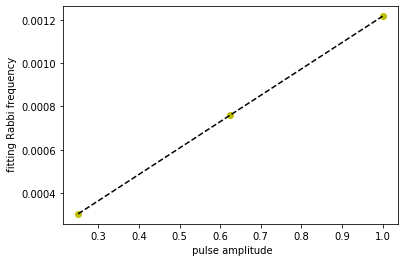

In [49]:
fit_coef   = np.polyfit(Amp_List, Freq_List, 1)
Rabi_linear  = np.poly1d(fit_coef)
plt.plot(Amp_List, Freq_List,'yo', Amp_List, Rabi_linear(Amp_List), '--k')
plt.xlabel(' pulse amplitude')
plt.ylabel(' fitting Rabbi frequency')